# We Clustering Project:

* Goal: Group customers into meaningful segments based on their transaction and demographic behavior.

## Metadata:

| Column Name          | Description                                                                 |
|----------------------|-----------------------------------------------------------------------------|
| **User_Id**          | Unique identifier for each customer.                                        |
| **Customer_Age**     | Age of the customer (in days or coded units).                               |
| **Trx_Vlu**          | Transaction value (monetary amount).                                        |
| **Trx_Age**          | Age of the transaction (days since occurrence or encoded).                  |
| **Trx_Rank**         | Rank/order of transaction for a given customer.                             |
| **Points**           | Loyalty points earned from transactions, proportional to transaction value. |
| **Category In English** | Transaction category (e.g., Fashion, Electronics, etc.).                 |
| **Mer_Id**           | Merchant identifier (categorical ID for merchants).                         |

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
from datetime import datetime, timedelta

# Data Manipulation:
import pandas as pd
import numpy as np

# Data Visualization:
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import express as px
import plotly.graph_objects as go

# Preprocessing:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer

# ML Models:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

# Model Evaluation:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

# Model Saving:
import joblib

# Random State:
RANDOM_STATE = 42   
np.random.seed(RANDOM_STATE)



# Data Understanding:

In [2]:
df = pd.read_csv("../data/raw/Cleaned_Data_Merchant_Level_2.csv")

In [4]:
df.shape

(43672, 8)

## Data Exploration:

In [5]:
df.head()

,User_Id,Customer_Age,Trx_Vlu,Trx_Age,Trx_Rank,Points,Category In English,Mer_Id
0,21053,362,2014.0,362,1,20140,Fashion,0
1,26472,368,1120.0,371,1,11200,Fashion,0
2,26472,368,850.0,368,2,8500,Fashion,0
3,27075,34,198.0,558,1,1980,Fashion,0
4,27417,413,240.0,413,1,2400,Fashion,0


In [6]:
# check data types:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43672 entries, 0 to 43671
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   User_Id              43672 non-null  int64  
 1   Customer_Age         43672 non-null  int64  
 2   Trx_Vlu              43672 non-null  float64
 3   Trx_Age              43672 non-null  int64  
 4   Trx_Rank             43672 non-null  int64  
 5   Points               43672 non-null  int64  
 6   Category In English  43672 non-null  object 
 7   Mer_Id               43672 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 2.7+ MB


In [7]:
# Summary statistics - Numerical
df.describe()

,User_Id,Customer_Age,Trx_Vlu,Trx_Age,Trx_Rank,Points,Mer_Id
count,43672.000000,43672.000000,43672.000000,43672.000000,43672.000000,43672.000000,43672.000000
mean,17173.411889,144.027844,331.224975,185.186664,1.265227,3312.249748,16.277111
std,9665.399084,114.764448,575.637414,121.989540,0.776549,5756.374137,16.099288
min,0.000000,1.000000,2.000000,1.000000,1.000000,20.000000,0.000000
25%,8710.750000,34.000000,122.000000,62.000000,1.000000,1220.000000,8.000000
50%,17561.000000,115.000000,189.350000,203.000000,1.000000,1893.500000,8.000000
75%,25634.250000,252.000000,310.000000,271.000000,1.000000,3100.000000,26.000000
max,33518.000000,682.000000,26380.000000,698.000000,17.000000,263800.000000,56.000000


In [8]:
# Summary statistics - Categorical::
df.describe(include= 'O')

,Category In English
count,43672
unique,7
top,Grocery
freq,30694


In [9]:
# Check duplicates:
df.duplicated().sum()

np.int64(0)

In [10]:
# Check missing values:
df.isnull().sum()

User_Id                0
Customer_Age           0
Trx_Vlu                0
Trx_Age                0
Trx_Rank               0
Points                 0
Category In English    0
Mer_Id                 0
dtype: int64

In [11]:
# unique values in each column
for col in df.columns:
    print(col, df[col].nunique())

User_Id 33457
Customer_Age 527
Trx_Vlu 5911
Trx_Age 573
Trx_Rank 17
Points 5911
Category In English 7
Mer_Id 56


* Data Visulization:

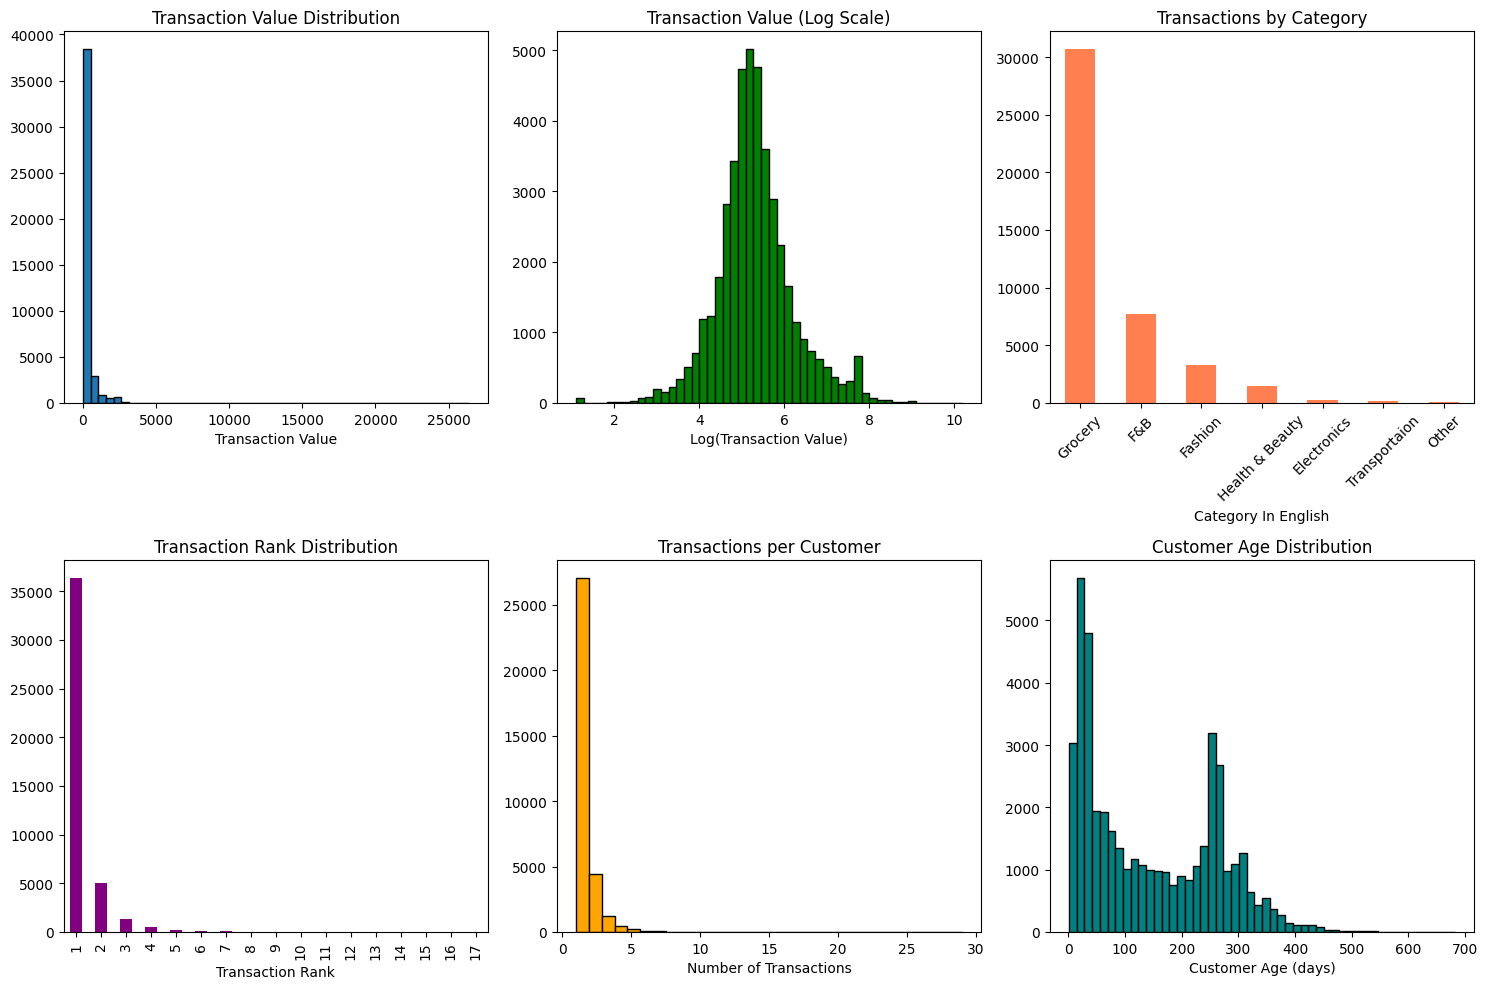

In [12]:
# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Transaction Value Distribution
axes[0, 0].hist(df['Trx_Vlu'], bins=50, edgecolor='black')
axes[0, 0].set_title('Transaction Value Distribution')
axes[0, 0].set_xlabel('Transaction Value')

# 2. Transaction Value (log scale - to see better)
axes[0, 1].hist(np.log1p(df['Trx_Vlu']), bins=50, edgecolor='black', color='green')
axes[0, 1].set_title('Transaction Value (Log Scale)')
axes[0, 1].set_xlabel('Log(Transaction Value)')

# 3. Category Distribution
df['Category In English'].value_counts().plot(kind='bar', ax=axes[0, 2], color='coral')
axes[0, 2].set_title('Transactions by Category')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Transaction Rank Distribution
df['Trx_Rank'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0], color='purple')
axes[1, 0].set_title('Transaction Rank Distribution')
axes[1, 0].set_xlabel('Transaction Rank')

# 5. Transactions per Customer
trx_per_customer = df.groupby('User_Id').size()
axes[1, 1].hist(trx_per_customer, bins=30, edgecolor='black', color='orange')
axes[1, 1].set_title('Transactions per Customer')
axes[1, 1].set_xlabel('Number of Transactions')

# 6. Customer Age Distribution
axes[1, 2].hist(df['Customer_Age'], bins=50, edgecolor='black', color='teal')
axes[1, 2].set_title('Customer Age Distribution')
axes[1, 2].set_xlabel('Customer Age (days)')

plt.tight_layout()
plt.show()



In [13]:
print(f"Average transactions per customer: {len(df) / df['User_Id'].nunique():.2f}")
print(f"Max transactions by one customer: {trx_per_customer.max()}")
print(f"Customers with only 1 transaction: {(trx_per_customer == 1).sum()}")

Average transactions per customer: 1.31
Max transactions by one customer: 29
Customers with only 1 transaction: 27048


In [14]:
df.head()

,User_Id,Customer_Age,Trx_Vlu,Trx_Age,Trx_Rank,Points,Category In English,Mer_Id
0,21053,362,2014.0,362,1,20140,Fashion,0
1,26472,368,1120.0,371,1,11200,Fashion,0
2,26472,368,850.0,368,2,8500,Fashion,0
3,27075,34,198.0,558,1,1980,Fashion,0
4,27417,413,240.0,413,1,2400,Fashion,0


# Feature Engineering For EDA:

* Aggregate to customer level
* RFM - Recency, Frequency, Monetary  | Total points per customer | most recent age 

In [15]:
customer_features = df.groupby('User_Id').agg({
    # Recency: Most recent transaction age
    'Trx_Age': 'min',
    
    # Frequency: Number of transactions
    'Trx_Rank': 'max',  # Max rank = total number of transactions
    
    # Monetary: Total spending
    'Trx_Vlu': ['sum', 'mean', 'max'],  # YOUR TURN: Why sum, mean, AND max?
    
    # Total Points
    'Points': 'sum',
    
    # Customer tenure
    'Customer_Age': 'max'  
}).reset_index()

# Flatten column names
customer_features.columns = ['_'.join(col).strip('_') for col in customer_features.columns]



In [16]:
 customer_features.shape


(33457, 8)

In [17]:
customer_features.head()


,User_Id,Trx_Age_min,Trx_Rank_max,Trx_Vlu_sum,Trx_Vlu_mean,Trx_Vlu_max,Points_sum,Customer_Age_max
0,0,281,1,442.7,442.7,442.7,4427,281
1,1,34,1,249.0,249.0,249.0,2490,34
2,2,236,1,300.0,300.0,300.0,3000,236
3,3,320,1,162.0,162.0,162.0,1620,320
4,4,407,1,70.0,70.0,70.0,700,407


In [18]:
customer_features.describe()

,User_Id,Trx_Age_min,Trx_Rank_max,Trx_Vlu_sum,Trx_Vlu_mean,Trx_Vlu_max,Points_sum,Customer_Age_max
count,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,3.345700e+04,33457.000000
mean,16749.849957,160.501240,1.211047,432.353681,318.068422,352.684464,4.323537e+03,160.492513
std,9676.959185,115.681993,0.643010,1306.338905,454.783721,579.721583,1.306339e+04,115.678080
min,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000e+01,1.000000
25%,8371.000000,41.000000,1.000000,150.000000,134.000000,142.000000,1.500000e+03,41.000000
50%,16740.000000,154.000000,1.000000,216.000000,194.000000,200.000000,2.160000e+03,154.000000
75%,25120.000000,259.000000,1.000000,364.000000,304.000000,320.000000,3.640000e+03,259.000000
max,33518.000000,682.000000,17.000000,165183.800000,10548.000000,26380.000000,1.651838e+06,682.000000


* Create Behavioral features:

In [19]:
# Create the Pivot Table 
cat_features = df.pivot_table(
    index='User_Id',
    columns='Category In English',
    values='Trx_Vlu',
    aggfunc='sum',
    fill_value=0
)

# Calculate Diversity and Favorite :
# Diversity: Count how many columns have a value > 0
diversity = (cat_features > 0).sum(axis=1).rename('Category_Diversity')

# Favorite: Find the column name with the highest value for each row
favorite = cat_features.idxmax(axis=1).rename('Favorite_Category')

# 3. Rename the pivot columns
cat_features.columns = [f'Cat_{col}' for col in cat_features.columns]

# 4. Merge everything once
new_stats = pd.concat([cat_features, diversity, favorite], axis=1)
customer_features = customer_features.merge(new_stats, on='User_Id', how='left')



In [20]:
 customer_features.shape


(33457, 17)

In [21]:
customer_features.head()

,User_Id,Trx_Age_min,Trx_Rank_max,Trx_Vlu_sum,Trx_Vlu_mean,Trx_Vlu_max,Points_sum,Customer_Age_max,Cat_Electronics,Cat_F&B,Cat_Fashion,Cat_Grocery,Cat_Health & Beauty,Cat_Other,Cat_Transportaion,Category_Diversity,Favorite_Category
0,0,281,1,442.7,442.7,442.7,4427,281,0.0,442.7,0.0,0.0,0.0,0.0,0.0,1,F&B
1,1,34,1,249.0,249.0,249.0,2490,34,0.0,0.0,249.0,0.0,0.0,0.0,0.0,1,Fashion
2,2,236,1,300.0,300.0,300.0,3000,236,0.0,300.0,0.0,0.0,0.0,0.0,0.0,1,F&B
3,3,320,1,162.0,162.0,162.0,1620,320,0.0,0.0,162.0,0.0,0.0,0.0,0.0,1,Fashion
4,4,407,1,70.0,70.0,70.0,700,407,0.0,0.0,0.0,70.0,0.0,0.0,0.0,1,Grocery


In [22]:
customer_features['Category_Diversity'].value_counts()

Category_Diversity
1    31901
2     1467
3       80
4        8
7        1
Name: count, dtype: int64

* Rename columns:


In [23]:
customer_features = customer_features.rename(columns={
    'Trx_Age_min': 'Recency', 
    'Trx_Rank_max': 'Frequency',  
    'Trx_Vlu_sum': 'Monetary_Total',
    'Trx_Vlu_mean': 'Monetary_Avg',
    'Trx_Vlu_max': 'Monetary_Max',
    'Points_sum': 'Total_Points',
    'Customer_Age_max': 'Customer_Tenure'
})

In [24]:
# Calculated features:
customer_features['Avg_Days_Between_Purchases'] = customer_features['Customer_Tenure'] / customer_features['Frequency']
customer_features['Points_Per_Transaction'] = customer_features['Total_Points'] / customer_features['Frequency']

In [25]:
customer_features[['Recency', 'Frequency', 'Monetary_Total' ,'Category_Diversity']].describe()

,Recency,Frequency,Monetary_Total,Category_Diversity
count,33457.000000,33457.000000,33457.000000,33457.000000
mean,160.501240,1.211047,432.353681,1.049526
std,115.681993,0.643010,1306.338905,0.232785
min,1.000000,1.000000,2.000000,1.000000
25%,41.000000,1.000000,150.000000,1.000000
50%,154.000000,1.000000,216.000000,1.000000
75%,259.000000,1.000000,364.000000,1.000000
max,682.000000,17.000000,165183.800000,7.000000


# EDA & Feature Engineering:

In [26]:
numeric_features = customer_features.select_dtypes(include='number').drop(columns=['User_Id'])

categorical_features = customer_features.select_dtypes(include='object')

* Heat Map:

Text(0.5, 1.0, 'Feature Correlation Matrix')

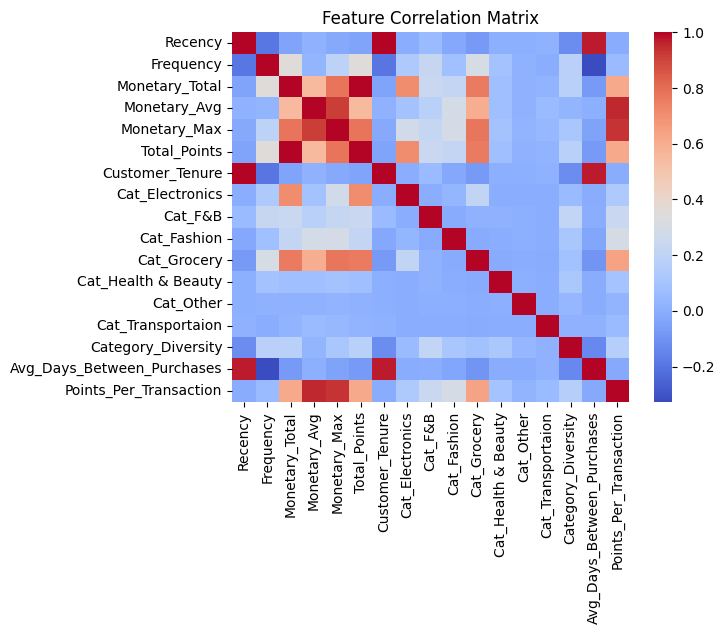

In [27]:
corr_matrix = numeric_features.corr()
sns.heatmap(corr_matrix, cmap= 'coolwarm')
plt.title('Feature Correlation Matrix')


* Find Highly Correlated Fearures:

In [28]:
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr.append((corr_matrix.columns[i], 
                            corr_matrix.columns[j], 
                            corr_matrix.iloc[i, j]))
            
for feat1, feat2, corr in high_corr:
    print(f"{feat1} <-> {feat2}: {corr:.3f}")

Recency <-> Customer_Tenure: 1.000
Recency <-> Avg_Days_Between_Purchases: 0.972
Monetary_Total <-> Total_Points: 1.000
Monetary_Avg <-> Monetary_Max: 0.917
Monetary_Avg <-> Points_Per_Transaction: 0.957
Monetary_Max <-> Points_Per_Transaction: 0.933
Customer_Tenure <-> Avg_Days_Between_Purchases: 0.972


* Feature Selection:

In [29]:
# Final clustering dataset
features_to_drop = [
    'User_Id', 'Favorite_Category','Total_Points', 'Monetary_Avg','Customer_Tenure', 'Points_Per_Transaction', 'Avg_Days_Between_Purchases'
    ]

clustering_data = customer_features.drop(columns=features_to_drop, errors='ignore')



In [30]:
clustering_data.head()

,Recency,Frequency,Monetary_Total,Monetary_Max,Cat_Electronics,Cat_F&B,Cat_Fashion,Cat_Grocery,Cat_Health & Beauty,Cat_Other,Cat_Transportaion,Category_Diversity
0,281,1,442.7,442.7,0.0,442.7,0.0,0.0,0.0,0.0,0.0,1
1,34,1,249.0,249.0,0.0,0.0,249.0,0.0,0.0,0.0,0.0,1
2,236,1,300.0,300.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,1
3,320,1,162.0,162.0,0.0,0.0,162.0,0.0,0.0,0.0,0.0,1
4,407,1,70.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,1


# Preprocessing:

* Scaling & Handling Skewness before clustering:

In [31]:
# Handle if there is negative or zero values
num_cols = clustering_data.select_dtypes(include=np.number).columns
clustering_data[num_cols] = clustering_data[num_cols].apply(lambda x: x.clip(lower=0))

In [32]:
log_transformer = FunctionTransformer(np.log1p, validate=False)

In [33]:
preprocessing_pipeline = Pipeline([
    ('log', log_transformer),
    ('scaler', RobustScaler())
])

In [34]:
# Fit the dataset:
X_scaled = preprocessing_pipeline.fit_transform(clustering_data)
X_scaled = pd.DataFrame(X_scaled, columns=clustering_data.columns)
print(X_scaled.shape)
X_scaled.describe()

(33457, 12)


,Recency,Frequency,Monetary_Total,Monetary_Max,Cat_Electronics,Cat_F&B,Cat_Fashion,Cat_Grocery,Cat_Health & Beauty,Cat_Other,Cat_Transportaion,Category_Diversity
count,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000
mean,-0.213942,0.075240,0.176886,0.161815,0.034350,0.994408,0.495504,-0.190036,0.189653,0.005860,0.022698,0.019696
std,0.603760,0.200100,0.987861,1.004229,0.468613,2.137511,1.631387,0.449380,1.002316,0.188235,0.357735,0.090708
min,-2.386313,0.000000,-4.850669,-5.199989,0.000000,0.000000,0.000000,-0.905143,0.000000,0.000000,0.000000,0.000000
25%,-0.716263,0.000000,-0.410843,-0.421051,0.000000,0.000000,0.000000,-0.905143,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.283737,0.000000,0.589157,0.578949,0.000000,0.000000,0.000000,0.094857,0.000000,0.000000,0.000000,0.000000
max,0.813527,2.197225,7.517325,6.031555,11.800650,9.913413,9.825039,1.054725,8.580544,7.747122,8.024535,1.386294


# Visaulize Clusters:

In [35]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2', 'PC3'])

print(f"Explained Variance Ratio per PC: {pca.explained_variance_ratio_}")
print(f"Total Information Retained: {sum(pca.explained_variance_ratio_):.2%}")


Explained Variance Ratio per PC: [0.41904189 0.25238526 0.16140178]
Total Information Retained: 83.28%


In [36]:
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', 
                    title='3D View of Customer Data (PCA)',
                    opacity=0.6)
fig.update_traces(marker=dict(size=3))
fig.show()


* The K-Distance Graph:

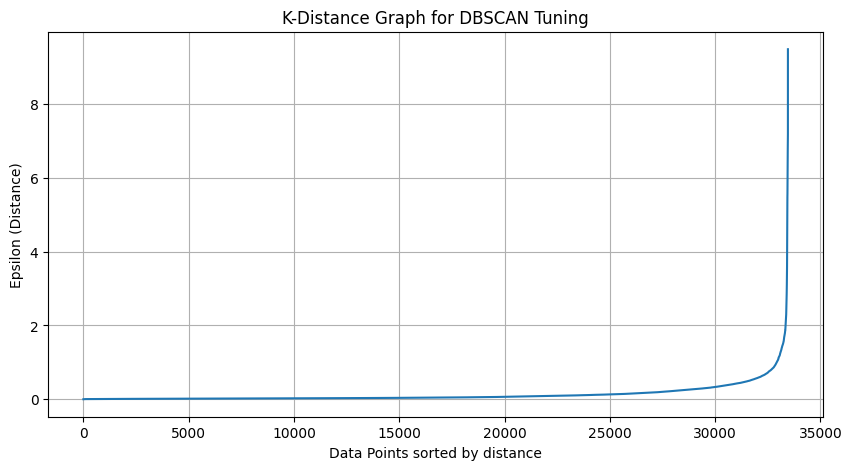

In [37]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_scaled)

distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, 9], axis=0) 

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('K-Distance Graph for DBSCAN Tuning')
plt.ylabel('Epsilon (Distance)')
plt.xlabel('Data Points sorted by distance')
plt.grid(True)
plt.show()

# Model Training :

In [38]:
models = [
    ("K-Means", KMeans(n_clusters=4, random_state=42)),
    ("Agglomerative", AgglomerativeClustering(n_clusters=4)),
    ("Gaussian Mixture", GaussianMixture(n_components=4, random_state=42)),
    ("DBSCAN", DBSCAN(eps=0.5, min_samples=20))
]

In [40]:
results = []

for name, model in models:
    try:  
        labels = model.fit_predict(X_scaled)
        
        # Calculate Cluster Count
        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

        # Calculate Metrics
        sil = round(silhouette_score(X_scaled, labels), 3)
        db = round(davies_bouldin_score(X_scaled, labels), 3)
        
        results.append({
            'Model': name,
            'Silhouette': sil,
            'Davies-Bouldin': db,
            'Clusters Found': n_clusters
        })
        
        print(f"{name}")
        print(f"Clusters Found: {n_clusters}")
        print(f"Silhouette Score: {sil}")
        print(f"Davies-Bouldin:   {db}")
        print('-'*80)

    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        continue

#Leaderboard
leaderboard = pd.DataFrame(results).sort_values(by='Silhouette', ascending=False)
leaderboard

K-Means
Clusters Found: 4
Silhouette Score: 0.668
Davies-Bouldin:   0.528
--------------------------------------------------------------------------------
Agglomerative
Clusters Found: 4
Silhouette Score: 0.663
Davies-Bouldin:   0.529
--------------------------------------------------------------------------------
Gaussian Mixture
Clusters Found: 4
Silhouette Score: 0.662
Davies-Bouldin:   0.614
--------------------------------------------------------------------------------
DBSCAN
Clusters Found: 10
Silhouette Score: 0.513
Davies-Bouldin:   1.368
--------------------------------------------------------------------------------


,Model,Silhouette,Davies-Bouldin,Clusters Found
0,K-Means,0.668,0.528,4
1,Agglomerative,0.663,0.529,4
2,Gaussian Mixture,0.662,0.614,4
3,DBSCAN,0.513,1.368,10


# Hyperparameter Tunning:

* K-Means:

In [42]:
param_grid = {
    'n_clusters': [3, 4, 5, 6],
    'init': ['k-means++', 'random'], 
    'n_init': [10, 20],
    'max_iter': [300]
}

In [ ]:
best_score = -1
best_params = {}

for params in ParameterGrid(param_grid):
    try:
        model = KMeans(random_state=42, **params)
        labels = model.fit_predict(X_scaled)
        
        score = silhouette_score(X_scaled, labels)
        
        if score > best_score:
            best_score = score
            best_params = params
            
    except Exception as e:
        continue


📈 New Best: Score 0.6387 | Params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10}
📈 New Best: Score 0.6678 | Params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 4, 'n_init': 10}
📈 New Best: Score 0.6678 | Params: {'init': 'random', 'max_iter': 300, 'n_clusters': 4, 'n_init': 10}

🏆 K-MEANS WINNER: 0.6678
⚙️ {'init': 'random', 'max_iter': 300, 'n_clusters': 4, 'n_init': 10}


In [45]:
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Optimal Parameters:    {best_params}")


Best Silhouette Score: 0.6678
Optimal Parameters:    {'init': 'random', 'max_iter': 300, 'n_clusters': 4, 'n_init': 10}


* Agglomerative:

In [47]:
param_grid = {
    'n_clusters': [3, 4, 5, 6],
    'linkage': ['ward', 'complete', 'average'] 
}


In [48]:
best_score = -1
best_params = {}

for params in ParameterGrid(param_grid):
    try:
        if params['linkage'] == 'ward':
            model = AgglomerativeClustering(metric='euclidean', **params)
        else:
            model = AgglomerativeClustering(metric='euclidean', **params)
            
        labels = model.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        
        if score > best_score:
            best_score = score
            best_params = params

    except Exception as e:
        continue


In [49]:
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Optimal Parameters:    {best_params}")


Best Silhouette Score: 0.6628
Optimal Parameters:    {'linkage': 'ward', 'n_clusters': 4}


* Gaussian Mixture:

In [50]:
param_grid = {
    'n_components': [3, 4, 5, 6],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'init_params': ['kmeans', 'random'],
    'max_iter': [200]
}

In [51]:
best_score = -1
best_params = {}

for params in ParameterGrid(param_grid):
    try:
        model = GaussianMixture(random_state=42, **params)
        labels = model.fit_predict(X_scaled)
        
        score = silhouette_score(X_scaled, labels)
        
        if score > best_score:
            best_score = score
            best_params = params
            
    except Exception as e:
        continue

In [52]:
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Optimal Parameters:    {best_params}")


Best Silhouette Score: 0.6712
Optimal Parameters:    {'covariance_type': 'tied', 'init_params': 'kmeans', 'max_iter': 200, 'n_components': 5}


*  Best Model:

In [53]:
final_model = GaussianMixture(
    n_components=5,            
    covariance_type='tied',    
    init_params='kmeans',
    max_iter=200,
    random_state=42
)

In [ ]:
final_labels = final_model.fit_predict(X_scaled)

array([0, 2, 0, ..., 1, 1, 0], shape=(33457,))

In [69]:
# Save Best Model:
joblib.dump(final_model,"final_model.pkl")

['final_model.pkl']

# Insights from Clusters:

In [74]:
df_profile = customer_features.copy()
df_profile['Cluster'] = final_labels

In [79]:
# Find the average of each cluster:
cluster_summary = df_profile.groupby('Cluster').agg({
    'Monetary_Total': 'mean',
    'Monetary_Avg': 'mean',
    'Frequency': 'mean',
    'Recency': 'mean',
    'Category_Diversity': 'mean',
    'Customer_Tenure': 'count' 
})

cluster_summary.rename(columns={'Customer_Tenure': 'Population'}, inplace=True)

In [80]:
#  Percentage of Total Customers
cluster_summary['Pct_Population'] = (cluster_summary['Population'] / cluster_summary['Population'].sum()) * 100

In [82]:
#  Sort by Monetary Total to identify VIPs 
cluster_summary = cluster_summary.sort_values(by='Monetary_Total', ascending=False)

In [ ]:
print("Final Cluster Profile Summary")
display(cluster_summary.style.background_gradient(cmap='Blues'))

,Monetary_Total,Monetary_Avg,Frequency,Recency,Category_Diversity,Population,Pct_Population
Cluster,,,,,,,
4,1475.652000,634.274366,1.257143,183.202857,1.222857,350,1.046119
2,635.883702,437.722855,1.202669,146.920969,1.163681,2847,8.509430
0,448.951245,276.828380,1.260491,190.780621,1.140396,5862,17.520997
3,447.487681,259.867003,1.369584,174.987256,1.245540,1177,3.517948
1,386.717747,311.993057,1.190862,153.445976,1.000043,23221,69.405506


### Profile Visualization:

In [ ]:
# Normalize data for easier visualization
scaler = MinMaxScaler().set_output(transform="pandas")

plot_data = scaler.fit_transform(cluster_summary.drop(columns=['Population', 'Pct_Population']))

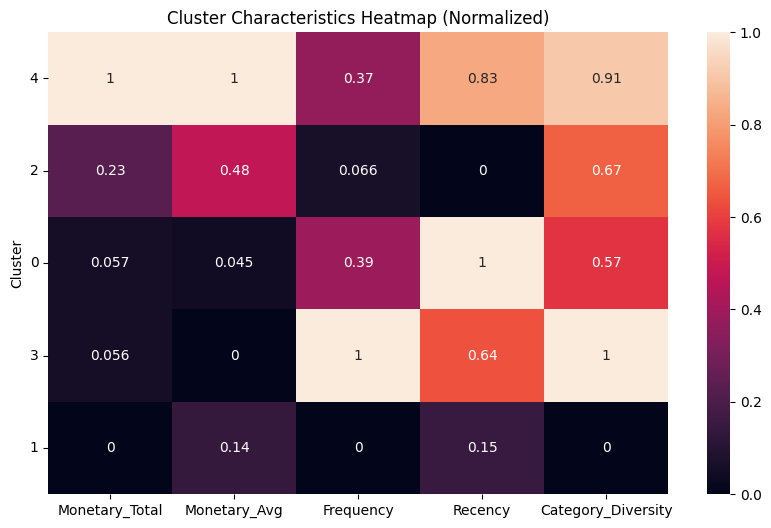

In [90]:
plt.figure(figsize=(10, 6))
sns.heatmap(plot_data, annot=True)
plt.title('Cluster Characteristics Heatmap (Normalized)')
plt.yticks(rotation=0)
plt.show()

#  Customer Segments & Insights

I identified 5 main customer clusters. 

### Cluster 4 – The Whales (VIPs)
A small group (~1%) who spend the most (around $1,475 each). They need personal attention and exclusive perks to stay loyal.  

### Cluster 2 – The Rising Stars
About 8.5% of customers who shopped recently and spent well (~$635). They’re engaged now, so it’s the perfect time to upsell and nurture them.  

### Cluster 3 – The Explorers
Around 3.5% who shop most often and across different categories. They love variety, so loyalty programs and rewards will keep them hooked.  

### Cluster 0 – The At‑Risk (Sleepers)
Roughly 17% who haven’t visited in months. A strong win‑back campaign with discounts or new product highlights can re‑ignite interest.  

### Cluster 1 – The One‑Timers
The largest group (~70%) who bought once and left (average spend $386). Keep costs low with automated emails and aim for a second purchase